In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt

from sklearn.preprocessing import OneHotEncoder

sns.set_theme(style = "whitegrid")

In [3]:
INDEX_TO_SEASON = {
    1: 'Primavera',
    2: 'Verão',
    3: 'Outono',
    4: 'Inverno'
}
INDEX_TO_WEATHER = {
    1: "Limpo/Parcialmente Nublado",
    2: "Neblina",
    3: "Neve/Chuvoso",
    4: "Chuva Forte/Neve + Névoa",
}

In [4]:
bikes = pd.read_csv("data/train.csv")
bikes = bikes.astype({"datetime":"datetime64[ns]"}).set_index("datetime")
bikes = bikes.drop(columns=["casual", "registered"])

bikes["season"] = bikes["season"].apply(lambda x: INDEX_TO_SEASON[x])
bikes["holiday"] = bikes["holiday"].apply(lambda x: "Sim" if x == 1 else "Não")
bikes["workingday"] = bikes["workingday"].apply(lambda x: "Sim" if x == 1 else "Não")
bikes["weather"] = bikes["weather"].apply(lambda x: INDEX_TO_WEATHER[x])

In [5]:
# quebrando por mês para fazer o foward fill, sem isso o asfreq insere muitos NaNs (os últimos dias de cada mês)
bikes_monthly = {(month.year, month.month):group.asfreq("H") for month, group in bikes.groupby(pd.Grouper(freq='1M'))}

groups = []
for month, group in bikes_monthly.items():
    nans = group.isna().any(axis=1).sum()
    if nans > 0:
        print(f"{month}: {nans} NaNs")
    groups.append(group.ffill())

bikes = pd.concat(groups)

(2011, 1): 25 NaNs
(2011, 2): 10 NaNs
(2011, 3): 10 NaNs
(2011, 4): 1 NaNs
(2011, 9): 3 NaNs
(2011, 10): 1 NaNs
(2012, 1): 3 NaNs
(2012, 2): 1 NaNs
(2012, 3): 1 NaNs
(2012, 4): 2 NaNs
(2012, 11): 1 NaNs


In [6]:
bikes = bikes.astype({
    "count" : int,
    "humidity" : int,
})

In [7]:
categorical_columns = ["season", "weather", "holiday", "workingday"]

for col in categorical_columns:
    ohe = OneHotEncoder(sparse=False,)
    new_cols = ohe.fit_transform(bikes[[col]])
    ohe.categories_
    bikes[[f"{col}={c}" for c in ohe.categories_[0]]] = new_cols

In [8]:
bikes = bikes.drop(columns = categorical_columns)

In [9]:
bikes

,temp,atemp,humidity,windspeed,count,season=Inverno,season=Outono,season=Primavera,season=Verão,weather=Chuva Forte/Neve + Névoa,weather=Limpo/Parcialmente Nublado,weather=Neblina,weather=Neve/Chuvoso,holiday=Não,holiday=Sim,workingday=Não,workingday=Sim
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,9.84,14.395,81,0.0000,16,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 01:00:00,9.02,13.635,80,0.0000,40,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 02:00:00,9.02,13.635,80,0.0000,32,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 03:00:00,9.84,14.395,75,0.0000,13,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2011-01-01 04:00:00,9.84,14.395,75,0.0000,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,15.58,19.695,50,26.0027,336,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 20:00:00,14.76,17.425,57,15.0013,241,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2012-12-19 21:00:00,13.94,15.910,61,15.0013,168,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [10]:
# Box plot para análise de outliers (em variáveis não categóricas)

non_categorical = ["temp","atemp","humidity","windspeed"]

# Normalização de valores (min max)
normalized_bikes = (bikes - bikes.min()) / (bikes.max() - bikes.min())

def plot_boxplot(bikes: pd.DataFrame, save=True, plot=False):
    fig, ax = plt.subplots(figsize=(18, 8))
    
    ax.set_title('Boxplot dos dados não categóricos normalizados', weight='bold', fontsize=25)
    data = pd.melt(bikes)
    data.rename(columns={"variable": "atributos", "value": "valores"}, inplace=True)
    sns.boxplot(x="atributos", y="valores",data=data)

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    
    if save:
        fig.savefig(f"preproc/pre_outlier_boxplot.png")
    
    if not plot:
        plt.close()

    return fig

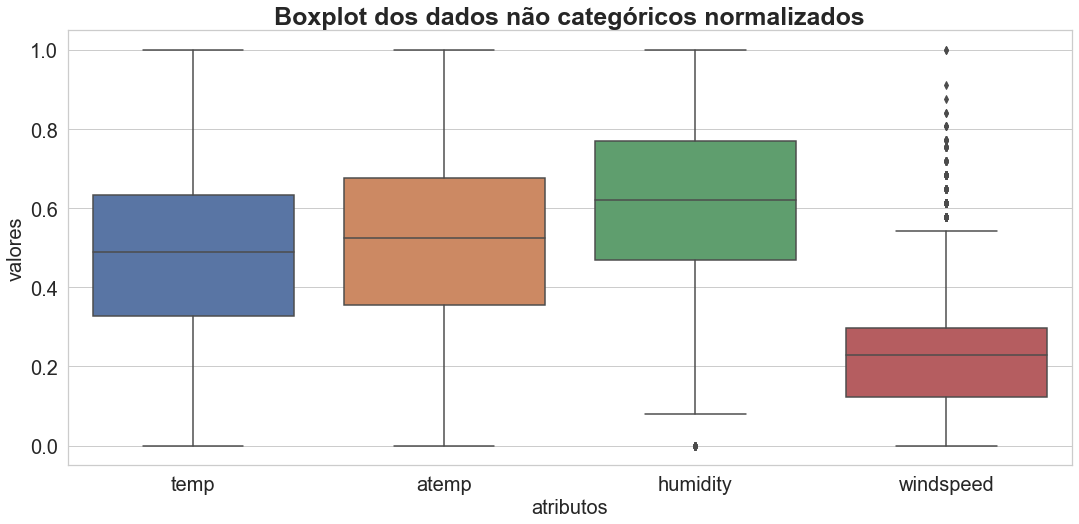

In [11]:
plot_boxplot(normalized_bikes[non_categorical])

In [22]:
categorical_features = [
    "season=Inverno",
    "season=Outono",
    "season=Primavera",
    "season=Verão",
    "weather=Chuva Forte/Neve + Névoa",
    "weather=Limpo/Parcialmente Nublado",
    "weather=Neblina",
    "weather=Neve/Chuvoso",
    "holiday=Não",
    "holiday=Sim",
    "workingday=Não",
    "workingday=Sim",
]

numerical_features = [
    "temp",
    "atemp",
    "humidity",
    "windspeed",
]

features = categorical_features + numerical_features
target = "count"

In [31]:
from scipy.stats import spearmanr, pearsonr

In [137]:
data = []
for feat in numerical_features:
    norm_target = (bikes[target] - bikes[target].min()) / (
        bikes[target].max() - bikes[target].min()
    )
    scorr, spvalue = spearmanr(bikes[feat], norm_target)
    # print(f"{feat}: {spvalue:.0e}")

    pcorr, ppvalue = pearsonr(bikes[feat], norm_target)
    # print(f"{feat}: {ppvalue:.0e}")
    # print()
    data.append(
        {
            "variável": feat,
            "pearson": pcorr,
            "p-valor pearson": ppvalue,
            "spearman": scorr,
            "p-valor spearman": spvalue,
        }
    )

corr_table = pd.DataFrame(data)
print(corr_table.round(2).to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &   variável &  pearson &  p-valor pearson &  spearman &  p-valor spearman \\
\midrule
0 &       temp &     0.40 &              0.0 &      0.41 &               0.0 \\
1 &      atemp &     0.39 &              0.0 &      0.41 &               0.0 \\
2 &   humidity &    -0.32 &              0.0 &     -0.35 &               0.0 \\
3 &  windspeed &     0.10 &              0.0 &      0.13 &               0.0 \\
\bottomrule
\end{tabular}



C:\Users\Gustavo-pessoal\AppData\Local\Temp\ipykernel_13176\4222728508.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(corr_table.round(2).to_latex())


In [97]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesRegressor(n_estimators=50)
clf = clf.fit(bikes[categorical_features], bikes[target])


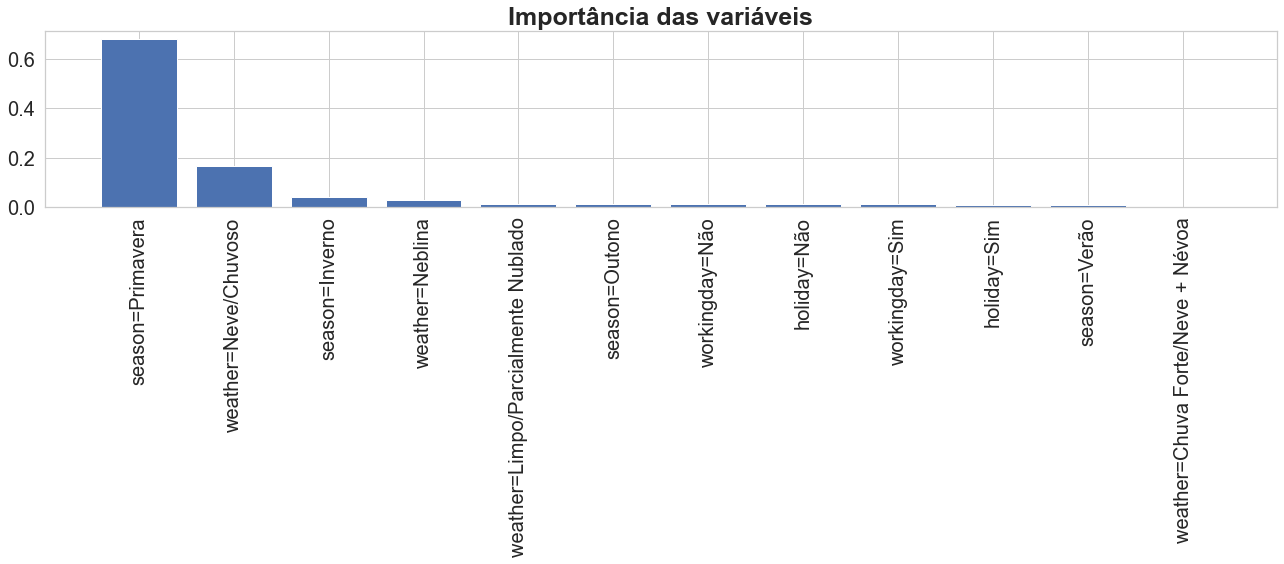

In [127]:
figure, ax = plt.subplots(figsize=(18, 8))
feature_importance = pd.DataFrame({"feature": clf.feature_names_in_, "importance": clf.feature_importances_}).sort_values("importance", ascending=False)
plt.bar(feature_importance.feature, feature_importance.importance)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.title("Importância das variáveis", weight='bold', fontsize=25)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"preproc/pre_feature_importance.png")
plt.show()

In [117]:
feature_importance.importance.cumsum()

2     0.680151
7     0.848499
0     0.888550
6     0.916099
5     0.930233
1     0.943726
10    0.956292
8     0.968199
11    0.979996
9     0.991060
3     0.999979
4     1.000000
Name: importance, dtype: float64